Total 200 subjects

ECG simulation on following 10 subjects:
1017174
1032124
1035446
1036193
1037159
1038870
1039625
1041615
1042450
1043050

Within these subject, you may have four (or three) files list as below:
1. electrodes_SSM_pre.vtk: the predicted electrodes based on conventional time-consuming project method;
2. torso_contour_full.vtk: extracted torso contour without post-processing
3. torso_contour.vtk: extracted torso contour after post-processing ---which might be missing in some subjects
4. torso_mesh.vtk: reconstructed 3D torso mesh

Steps:
1. Download paraview and understand some basic functions.
2. Learn the 10 electrode location and definition.
3. Load torso_mesh.vtk using paraview and identify the locations of 10 electrodes on the torso surface (you must need to double check to confirm it is extractor on the surface).
4. You might could refer to the other two files, i.e., electrodes_SSM_pre.vtk and torso_contour_full.vtk, to help you to know the location of the 10 electrodes.
5. Instead of extracting single point for each electrode location, you might could select several points (such as 10 points) as the potential electrode location. However, you need to make sure you label the selected points with corresponding electrode location label, such as V1, V2, etc. Also, please try your best to control the number of selected points, as more points means larger uncertainty/ error.
6. Please try to save the selected points into .vtk file with corresponding label. Otherwise, if it is too difficult to save it as .vtk directly via paraview. You could try to extract the coordinates of each points with corresponding label using excel. Then, you could write a python code and convert these coordinates into .vtk files for visual check.
7. The order of electrodes should be: LA, RA, LL, RL, V1, V2, ..., V6
8. Deadline: 24 July 2024 for 10 cases.

Here is the final model and result information:

*Model*

**TIM**: ./log/net_model_TIM_64kp_30resample.pkl  
**TIM w/o kp**: ./log/net_model_TIM_30resample_no_kp.pkl  
**TIM w/o recon**: ./log/net_model_TIM_30resample_no_recon.pkl  
**PCN_encoder + 3FC**: ./log/net_model_pcn_no_recon_1resample.pkl  

*Result*

**TIM**: ./results/*/electrodes_TIM_64kp_30rr_pre_v02.csv -- why v02 is because i accidently delete vo1 for the 10 cases for simulation, so i rerun the inference, and use v02 instead.

*ECG simulation*

**Simulation code**: ./Users/lei/Library/CloudStorage/OneDrive-UniversityofSouthampton/Oxford/Research/2023_TMI_MI_inference/Cardiac_Personalisation-SenAnalysis/src/simulate_QRS_with_scars.py  
**Simulation required files**: ./Users/lei/Library/CloudStorage/OneDrive-UniversityofSouthampton/Oxford/Research/2023_TMI_MI_inference/meta_data/UKB_clinical_data/*/*_electrodePositions_pre.csv (from prediction)  
**TIM simulation results**: ./dataset_cardiac_mesh/*/*_simulated_ECG_normal_pre.csv  
**gd simulation results**: ./dataset_cardiac_mesh/*/*_simulated_ECG_normal_gd.csv  


*3D Mesh*

**Biventricle**: ./Users/lei/Library/CloudStorage/OneDrive-UniversityofSouthampton/Oxford/Research/2023_ECG_inference/dataset_UKB/data_cardiac_mesh/*/*_epi.vtk
                                                  /*_lv.vtk
                                                  /*_rv.vtk
                                                  /*_SUR.vtk
                                                  /*_TET.vtk

**Torso**: ./dataset_mesh/*/torso_mesh.vtk
                           /torso_contour_full.vtk
                           /torso_contour.vtk (may be missing for some files)
                           /electrodes_gd.vtk
                           /electrodes_SSM.vtk

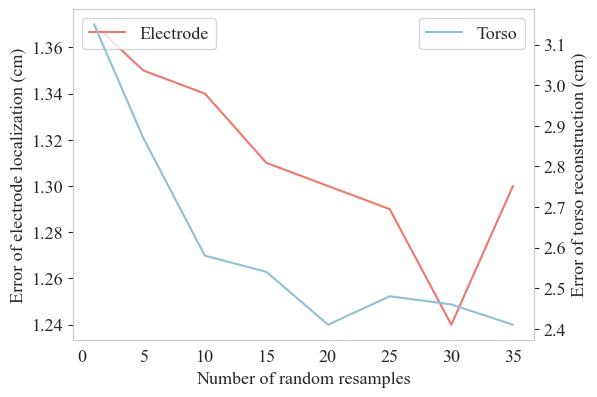

In [81]:
import matplotlib.pyplot as plt

# Set font properties globally
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 13

# Example data
resample = [1, 5, 10, 15, 20, 25, 30, 35]
torso_accuracy = [3.15, 2.87, 2.58, 2.54, 2.41, 2.48, 2.46, 2.41]
torso_std = [0.339, 0.360, 0.287, 0.310, 0.315, 0.303, 0.309, 0.314]
electrode_accuracy = [1.37, 1.35, 1.34, 1.31, 1.30, 1.29, 1.24, 1.30]
electrode_std = [0.319, 0.401, 0.354, 0.362, 0.333, 0.310, 0.292, 0.334]

fig, ax1 = plt.subplots(figsize=(6.5, 4.5))

# Plot electrode accuracy with specified color and std
ax1.errorbar(resample, electrode_accuracy, fmt='-', label='Electrode', color='#f0776d', capsize=5)
ax1.set_xlabel('Number of random resamples')
ax1.set_ylabel('Error of electrode localization (cm)')
ax1.tick_params('y')

# Create a second y-axis to plot torso accuracy with specified color and std
ax2 = ax1.twinx()
ax2.errorbar(resample, torso_accuracy, fmt='-', label='Torso', color='#91C0D5', capsize=5)
ax2.set_ylabel('Error of torso reconstruction (cm)')
ax2.tick_params('y')

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

fig.tight_layout(pad=2.0)
ax1.grid(False)
ax2.grid(False)

# Save the figure with extra padding to avoid cropping
plt.savefig('./results/fig_resample.pdf', format='pdf', bbox_inches='tight')
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import csv
from collections import defaultdict
import glob
import os

#BMI: Data-Field 21001-----ukb45079.csv
#sex: Data-Field 31-----ukb45078.csv
#age: Data-Field 21003-----ukb45078.csv
# Summary of diagnoses: Data-Field 41270-----ukb46186.csv

maindir = '/Users/lei/Library/CloudStorage/OneDrive-UniversityofSouthampton/Oxford/Research/Script/'
infofile = maindir + 'ukb46186.csv'

data_list = os.listdir('./dataset_mesh')

columns_eid = []
columns_BMI, columns_age, columns_sex, columns_disease = [], [], [], []
columns_1d, columns_2d, columns_3d, columns_4d = [], [], [], []
with open(infofile) as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader: # read a row as {column1: value1, column2: value2,...}
        if row['eid'] in data_list:
            columns_eid.append(row['eid'])
            columns_age.append(row['41270-0.13'])
            columns_sex.append(row['41270-0.14'])
            columns_1d.append(row['41270-0.15'])
            columns_2d.append(row['41270-0.16'])
            columns_3d.append(row['41270-0.17'])
            columns_4d.append(row['41270-0.222'])

list = {'eid': columns_eid, 'disease-1.3': columns_age, 'disease-1.4': columns_sex, 'disease-1.5': columns_1d, 'disease-1.6': columns_2d, 'disease-1.7': columns_3d, 'disease-1.8': columns_4d}
df = pd.DataFrame(list)
df.to_csv('./UKB_metadata.csv', encoding='gbk', index=False)

print('Lei, well done!')


In [48]:
import pandas as pd
import numpy as np
import csv
from collections import defaultdict
import glob

#BMI: Data-Field 21001-----ukb45079.csv
#sex: Data-Field 31-----ukb45078.csv
#age: Data-Field 21003-----ukb45078.csv
# Summary of diagnoses: Data-Field 41270-----ukb46186.csv

maindir = '/Users/lei/Library/CloudStorage/OneDrive-UniversityofSouthampton/Oxford/Research/Script/'
infofile = maindir + 'UKB-paired data info.csv'

data_list = os.listdir('./results')
output_file = './UKB_metadata.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(infofile)

# Filter rows where 'eid' is in data_list
filtered_df = df[df['eid'].astype(str).isin(data_list)]

# Save the filtered DataFrame to a new CSV file
filtered_df.to_csv(output_file, index=False)

print('Lei, well done!')


/var/folders/7k/qhhhfb0177gbf46snn4715qw0000gn/T/ipykernel_54663/1223282706.py:19: DtypeWarning: Columns (31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(infofile)


Lei, well done!


In [100]:
import numpy as np
from scipy.stats import pearsonr
import glob
import pandas as pd

datapath = './dataset_cardiac_mesh'
datafile = sorted(glob.glob(datapath + '/1*'))

# Initialize a list to store the results
results = []

# Define the column names
column_names = ['mesh_name', 'I', 'II', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

for subjectid in range(len(datafile)):
    subject_name = datafile[subjectid].replace(datapath, '').replace('/', '')
    predict_ecg_name = datafile[subjectid] + '/' + subject_name + '_simulated_ECG_normal_pre.csv'
    gd_ecg_name = datafile[subjectid] + '/' + subject_name + '_simulated_ECG_normal_gd.csv'
    ecg_pre = np.loadtxt(predict_ecg_name, delimiter=',') 
    ecg_gd = np.loadtxt(gd_ecg_name, delimiter=',')
    
    n_leads = ecg_pre.shape[0]
    correlations = [subject_name]
    
    for lead in range(n_leads):
        correlation_coefficient, p_value = pearsonr(ecg_pre[lead, :], ecg_gd[lead, :])
        print(f"ECG Pearson correlation coefficient for {subject_name}, lead {lead+1}: {correlation_coefficient:.4f}")
        correlations.append(correlation_coefficient)
    
    results.append(correlations)

# Create a DataFrame from the results with the specified columns
results_df = pd.DataFrame(results, columns=column_names)

# Save the DataFrame to a CSV file
results_csv_path = './results/average_ecg_similarity.csv'
results_df.to_csv(results_csv_path, index=False)


ECG Pearson correlation coefficient for 1017174, lead 1: 0.9975
ECG Pearson correlation coefficient for 1017174, lead 2: 0.9953
ECG Pearson correlation coefficient for 1017174, lead 3: 0.9979
ECG Pearson correlation coefficient for 1017174, lead 4: 0.9945
ECG Pearson correlation coefficient for 1017174, lead 5: 0.9987
ECG Pearson correlation coefficient for 1017174, lead 6: 0.9980
ECG Pearson correlation coefficient for 1017174, lead 7: 0.9434
ECG Pearson correlation coefficient for 1017174, lead 8: 0.9965
ECG Pearson correlation coefficient for 1032124, lead 1: 0.9937
ECG Pearson correlation coefficient for 1032124, lead 2: 0.9983
ECG Pearson correlation coefficient for 1032124, lead 3: 0.9997
ECG Pearson correlation coefficient for 1032124, lead 4: 0.9882
ECG Pearson correlation coefficient for 1032124, lead 5: 0.9745
ECG Pearson correlation coefficient for 1032124, lead 6: 0.9693
ECG Pearson correlation coefficient for 1032124, lead 7: 0.9921
ECG Pearson correlation coefficient for 

c:\Users\lei.li\AppData\Local\miniconda3\Lib\site-packages\pyvista\jupyter\notebook.py:37: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (c:\Users\lei.li\AppData\Local\miniconda3\Lib\site-packages\trame\widgets\__init__.py)

Falling back to a static output.
  warnings.warn(


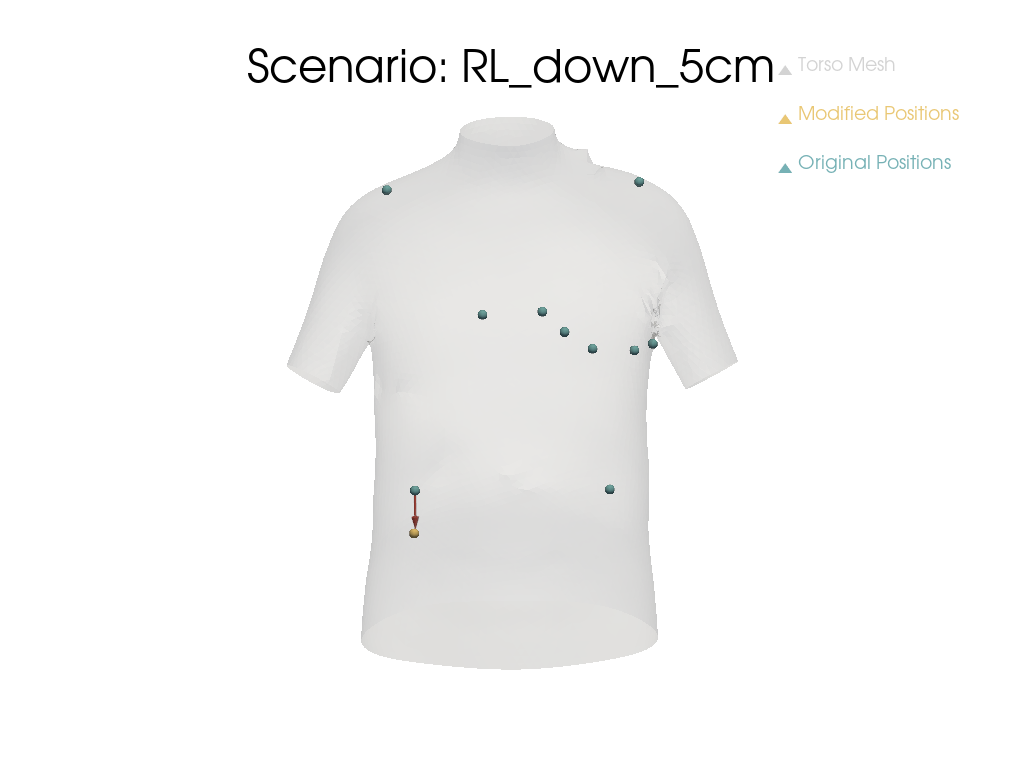

c:\Users\lei.li\AppData\Local\miniconda3\Lib\site-packages\pyvista\jupyter\notebook.py:37: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (c:\Users\lei.li\AppData\Local\miniconda3\Lib\site-packages\trame\widgets\__init__.py)

Falling back to a static output.
  warnings.warn(


Saved scenario: RL_down_5cm
Saved scenario: RL_down_5cm as .csv file


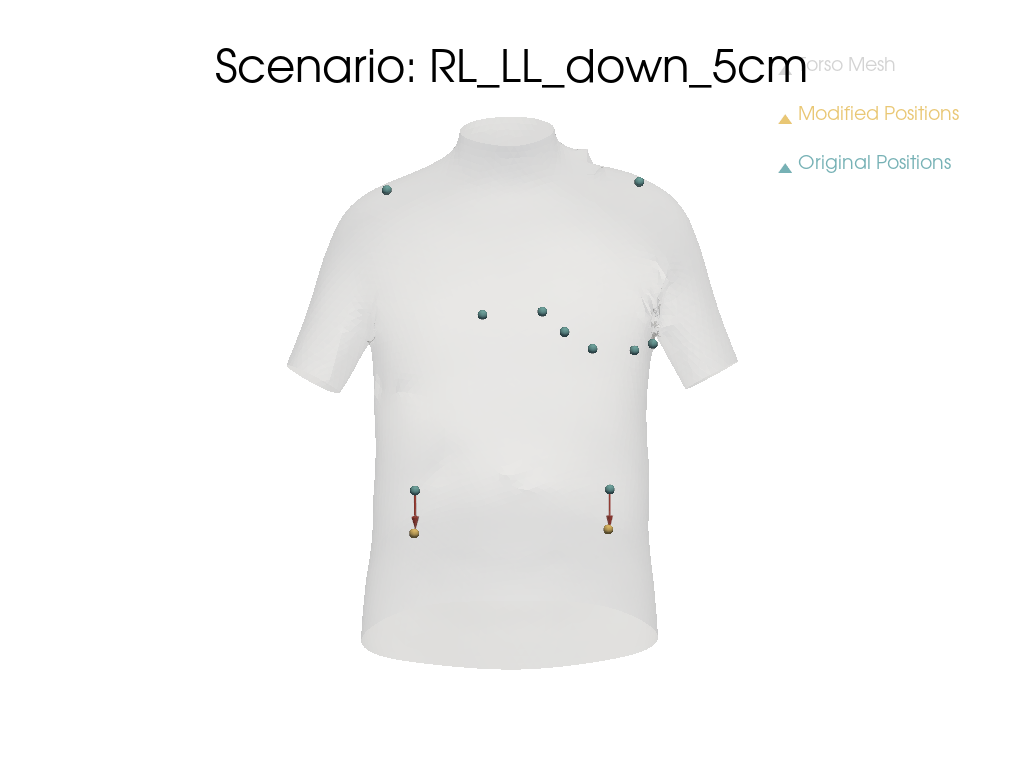

c:\Users\lei.li\AppData\Local\miniconda3\Lib\site-packages\pyvista\jupyter\notebook.py:37: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (c:\Users\lei.li\AppData\Local\miniconda3\Lib\site-packages\trame\widgets\__init__.py)

Falling back to a static output.
  warnings.warn(


Saved scenario: RL_LL_down_5cm
Saved scenario: RL_LL_down_5cm as .csv file


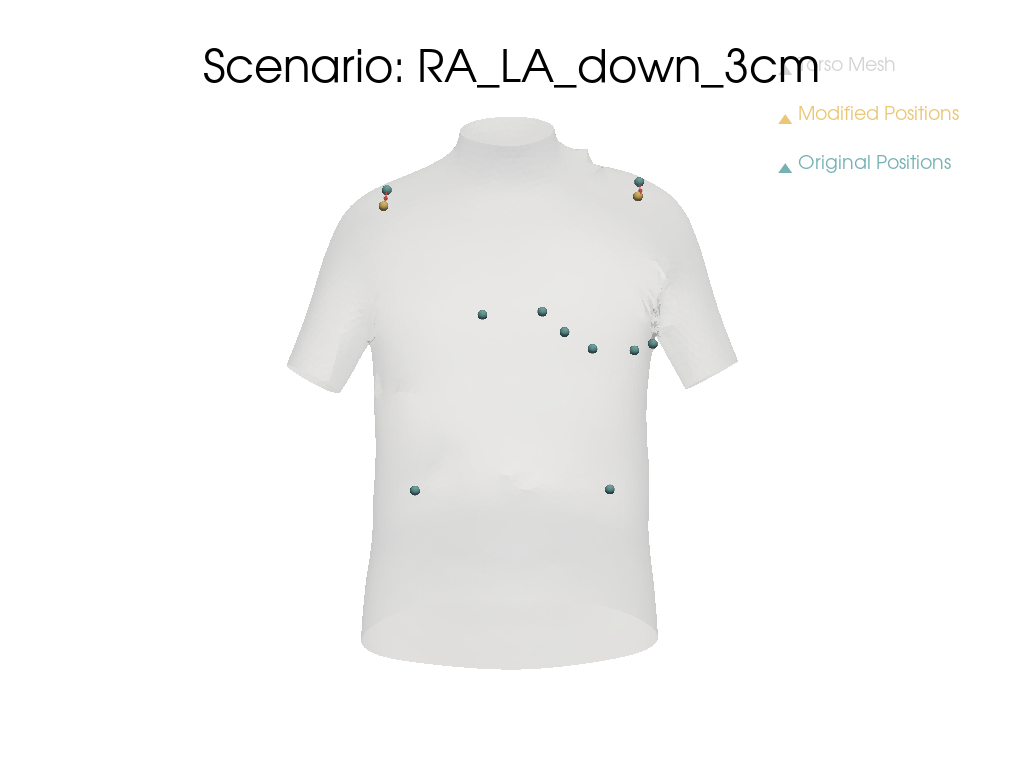

c:\Users\lei.li\AppData\Local\miniconda3\Lib\site-packages\pyvista\jupyter\notebook.py:37: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (c:\Users\lei.li\AppData\Local\miniconda3\Lib\site-packages\trame\widgets\__init__.py)

Falling back to a static output.
  warnings.warn(


Saved scenario: RA_LA_down_3cm
Saved scenario: RA_LA_down_3cm as .csv file


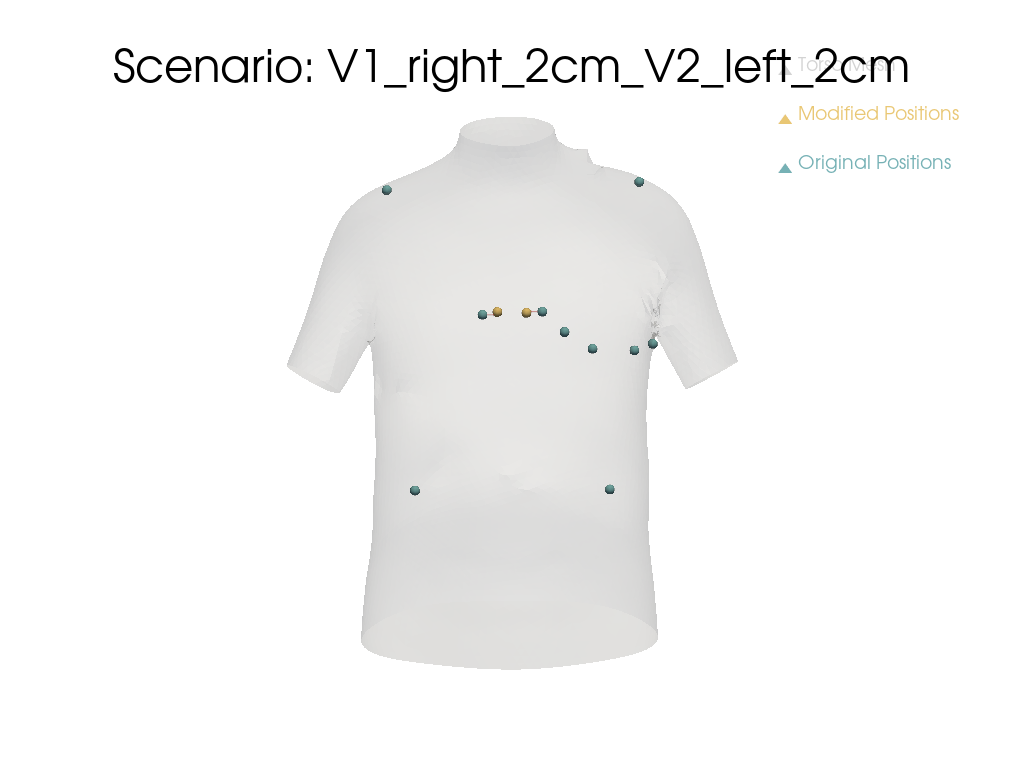

Saved scenario: V1_right_2cm_V2_left_2cm
Saved scenario: V1_right_2cm_V2_left_2cm as .csv file


c:\Users\lei.li\AppData\Local\miniconda3\Lib\site-packages\pyvista\jupyter\notebook.py:37: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (c:\Users\lei.li\AppData\Local\miniconda3\Lib\site-packages\trame\widgets\__init__.py)

Falling back to a static output.
  warnings.warn(


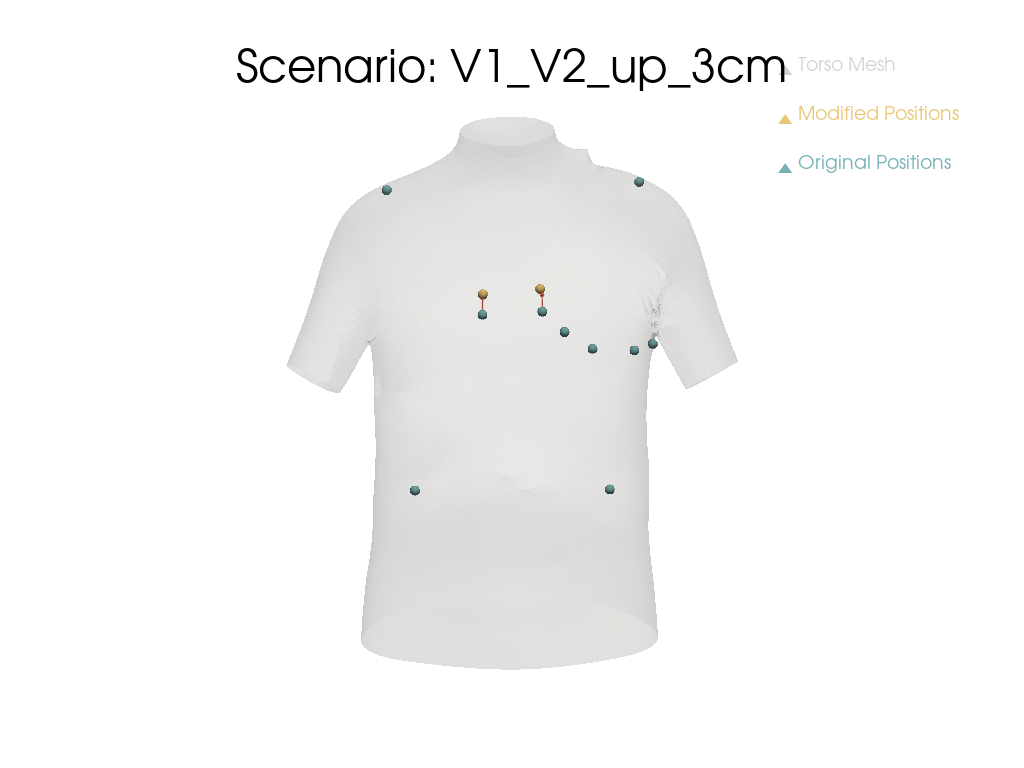

Saved scenario: V1_V2_up_3cm
Saved scenario: V1_V2_up_3cm as .csv file


c:\Users\lei.li\AppData\Local\miniconda3\Lib\site-packages\pyvista\jupyter\notebook.py:37: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (c:\Users\lei.li\AppData\Local\miniconda3\Lib\site-packages\trame\widgets\__init__.py)

Falling back to a static output.
  warnings.warn(


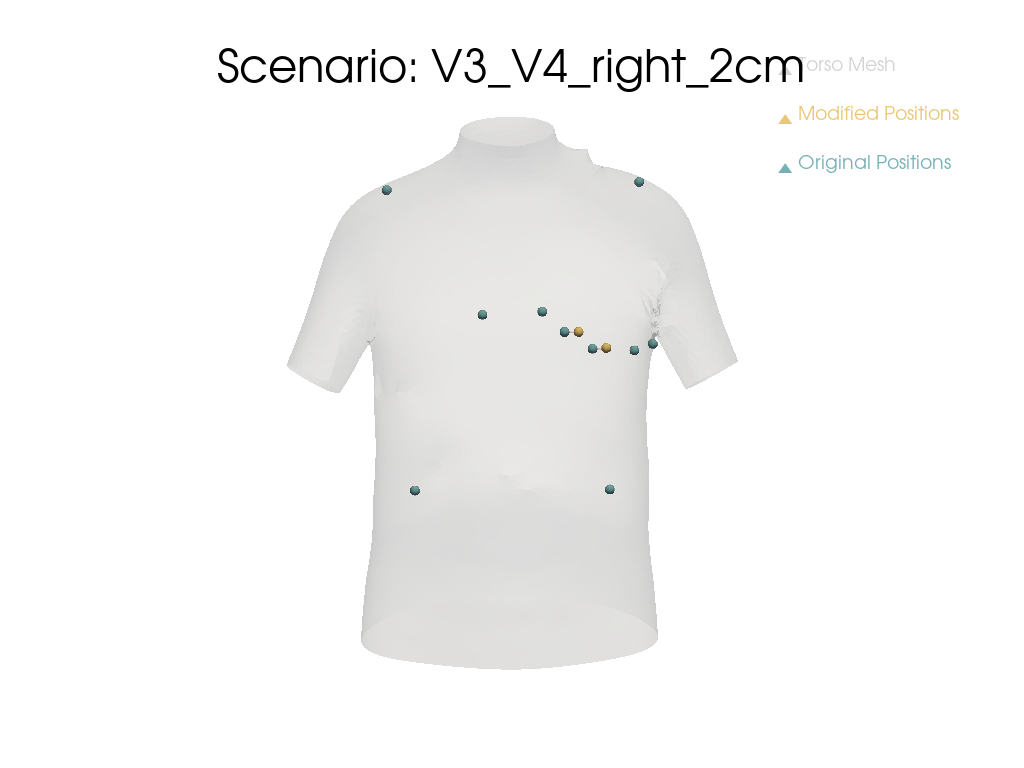

c:\Users\lei.li\AppData\Local\miniconda3\Lib\site-packages\pyvista\jupyter\notebook.py:37: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (c:\Users\lei.li\AppData\Local\miniconda3\Lib\site-packages\trame\widgets\__init__.py)

Falling back to a static output.
  warnings.warn(


Saved scenario: V3_V4_right_2cm
Saved scenario: V3_V4_right_2cm as .csv file


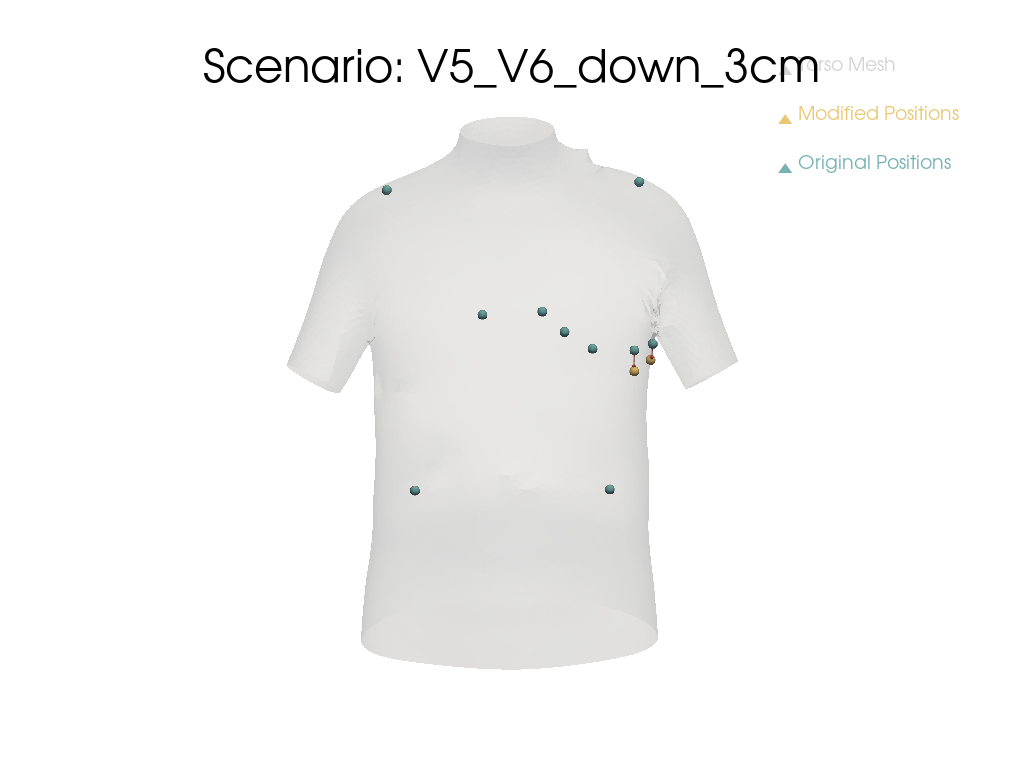

Saved scenario: V5_V6_down_3cm
Saved scenario: V5_V6_down_3cm as .csv file


In [45]:
import numpy as np
import pyvista as pv
import pandas as pd

# Define labels and directory
electrode_labels_list = ['LA', 'RA', 'LL', 'RL', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
dir = './results/ecg_simulation_visual/1041615/'
unit = 10  # Ensure this unit matches with torso model's measurement
rotation_matrix = np.array([[-1, 0, 0], [0, -1, 0], [0, 0, 1]])  # for torso coordinate

# Load the torso mesh
torso_mesh = pv.read(dir + "torso_mesh.vtk")

# Load the electrodes as a point cloud
original_electrode_mesh = pv.read(dir + "electrodes_gd.vtk")
original_coords = original_electrode_mesh.points.copy()

# Apply rotation matrix for correct orientation
torso_mesh.points = np.dot(torso_mesh.points, rotation_matrix.T)
original_coords = np.dot(original_coords, rotation_matrix.T)

# Pre-compute the normals for the torso mesh
torso_mesh.compute_normals(inplace=True)

# Visualization function
def visualize_movement(original_coords, modified_coords, movement_vectors, title):
    plotter = pv.Plotter()
    plotter.set_background("white")
    plotter.add_mesh(torso_mesh, color="lightgrey", opacity=0.15, label="Torso Mesh")
    plotter.view_vector(vector=[0, 1, 0])  # Adjust vector for desired orientation

    modified_points = pv.PolyData(modified_coords)
    plotter.add_mesh(modified_points, color="#E9C774", point_size=10, render_points_as_spheres=True, label="Modified Positions")

    original_points = pv.PolyData(original_coords)
    plotter.add_mesh(original_points, color="#76B1B5", point_size=10, render_points_as_spheres=True, label="Original Positions")

    for i, (orig, vec) in enumerate(zip(original_coords, movement_vectors)):
        if np.linalg.norm(vec) > 0:
            plotter.add_arrows(orig[np.newaxis], vec[np.newaxis], mag=1, opacity=1, color="#D95A4F") 

    plotter.add_legend()
    plotter.add_title(title)
    plotter.show()

# Adjusted movement function
def move_on_surface_and_save(electrode_indices, directions, distances, filename_suffix):
    electrode_coords = original_coords.copy()
    movement_vectors = np.zeros_like(electrode_coords)
    
    for idx, direction, distance in zip(electrode_indices, directions, distances):
        electrode_position = electrode_coords[idx]
        closest_point_idx = torso_mesh.find_closest_point(electrode_position)
        distance = distance * unit
        
        # Get the normal at this point
        normal = torso_mesh.point_normals[closest_point_idx]

        # For up/down, move along a vector perpendicular to both the normal and a global direction
        if direction in ('up', 'down'):
            # Define "up" as perpendicular to the surface normal in the horizontal plane
            up_direction = np.array([1, 0, 0])  # Z-axis as global up
            perpendicular = np.cross(normal, up_direction)
            if np.linalg.norm(perpendicular) < 1e-6:
                perpendicular = np.cross(normal, [1, 0, 0])
            perpendicular = perpendicular / np.linalg.norm(perpendicular)

            movement_vector = -perpendicular * distance if direction == 'up' else perpendicular * distance
        else:
            # Left/right movement along tangent
            tangent = np.cross(normal, [0, 0, 1])
            if np.linalg.norm(tangent) < 1e-6:
                tangent = np.cross(normal, [0, 1, 0])
            tangent = tangent / np.linalg.norm(tangent)
            movement_vector = -tangent * distance if direction == 'right' else tangent * distance

        # Apply the movement vector
        new_position = electrode_position + movement_vector
        projected_idx = torso_mesh.find_closest_point(new_position)
        electrode_coords[idx] = torso_mesh.points[projected_idx]
        movement_vectors[idx] = movement_vector

    # Visualize and save results
    visualize_movement(original_coords, electrode_coords, movement_vectors, f"Scenario: {filename_suffix}")
    
    modified_electrode_mesh = original_electrode_mesh.copy()
    modified_electrode_mesh.points = np.dot(electrode_coords, rotation_matrix.T)
    modified_electrode_mesh.save(f"{dir}electrodes_gd_{filename_suffix}.vtk")
    print(f"Saved scenario: {filename_suffix}")

    # Save the modified electrode positions as a CSV file
    electrode_coords = np.dot(electrode_coords, rotation_matrix.T)
    electrode_data = pd.DataFrame(electrode_coords*0.1)
    electrode_data.to_csv(f"{dir}1041615_electrodePositions_gd_{filename_suffix}.csv", index=False, header=False)
    print(f"Saved scenario: {filename_suffix} as .csv file")

# Define scenarios
scenarios = [
    ([3], ['down'], [5.0], "RL_down_5cm"),
    ([2, 3], ['down', 'down'], [5.0, 5.0], "RL_LL_down_5cm"),
    ([0, 1], ['down', 'down'], [3, 3], "RA_LA_down_3cm"),
    ([4, 5], ['right', 'left'], [2, 2], "V1_right_2cm_V2_left_2cm"),
    ([4, 5], ['up', 'up'], [3, 3], "V1_V2_up_3cm"),
    ([6, 7], ['right', 'right'], [2, 2], "V3_V4_right_2cm"),
    ([8, 9], ['down'] * 2, [3] * 2, "V5_V6_down_3cm")   
]

# Execute each scenario
for electrode_indices, directions, distances, filename_suffix in scenarios:
    move_on_surface_and_save(electrode_indices, directions, distances, filename_suffix)


start processing case: 1017174
Saved ./dataset_cardiac_mesh/Electrode_10subjects\1017174\1017174_electrodePositions_gd.csv
start processing case: 1032124
Saved ./dataset_cardiac_mesh/Electrode_10subjects\1032124\1032124_electrodePositions_gd.csv
start processing case: 1035446
Saved ./dataset_cardiac_mesh/Electrode_10subjects\1035446\1035446_electrodePositions_gd.csv
start processing case: 1036193
Saved ./dataset_cardiac_mesh/Electrode_10subjects\1036193\1036193_electrodePositions_gd.csv
start processing case: 1037159
Saved ./dataset_cardiac_mesh/Electrode_10subjects\1037159\1037159_electrodePositions_gd.csv
start processing case: 1038870
Saved ./dataset_cardiac_mesh/Electrode_10subjects\1038870\1038870_electrodePositions_gd.csv
start processing case: 1039625
Saved ./dataset_cardiac_mesh/Electrode_10subjects\1039625\1039625_electrodePositions_gd.csv
start processing case: 1041615
Saved ./dataset_cardiac_mesh/Electrode_10subjects\1041615\1041615_electrodePositions_gd.csv
start processing

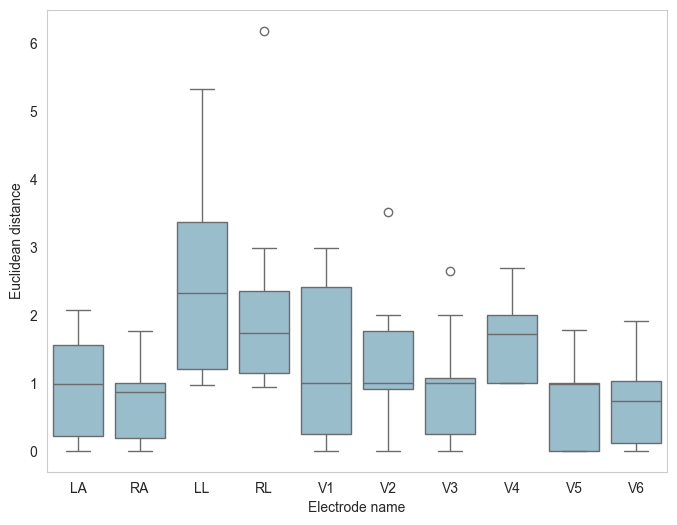

In [16]:
import pyvista as pv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns

data_list = os.listdir('./results/ecg_simulation_visual/simulation_subject_mesh')
electrode_labels_list = ['LA', 'RA', 'LL', 'RL', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
electrode_labels = np.array(electrode_labels_list)[:, np.newaxis]

unit = 0.1
all_distances = {label: [] for label in electrode_labels_list}
distances = []  # To store distances for each subject
subject_labels = []
filename_distances = []  # To store distances with filenames
all_results =  []

for filename in data_list:
    # Construct the full file path
    print('start processing case: ' + filename)

    electrode_gd_path_yilin = os.path.join('./results/electrode_gd_200cases_by_yilin/after_' + filename + '.csv')
    if not os.path.exists(electrode_gd_path_yilin):
        print('file missing: ' + filename)
        continue    
    df = pd.read_csv(electrode_gd_path_yilin)
    df[['X', 'Y', 'Z']] *= unit
    # Create a dictionary to map labels to coordinates
    label_to_coords = {label: coords for coords, label in zip(df[['X', 'Y', 'Z']].values, df['Label'])}
    pc_electrode_gd_yilin = np.array([label_to_coords[label] for label in electrode_labels_list])

    # Save pc_electrode_gd_yilin to CSV in the specified folder
    output_filename = os.path.join('./dataset_cardiac_mesh/Electrode_10subjects', filename, filename + '_electrodePositions_gd.csv')
    pd.DataFrame(pc_electrode_gd_yilin.round(3)).to_csv(output_filename, index=False, header=False, float_format="%.3f")
    print(f'Saved {output_filename}')

    electrode_gd_path_lei = os.path.join('./results/ecg_simulation_visual/Electrode_10subjects_labeled_by_Lei/after_' + filename + '_electrode_lei.csv')
    if not os.path.exists(electrode_gd_path_lei):
        print('file missing: ' + filename)
        continue    
    df = pd.read_csv(electrode_gd_path_lei)
    df[['X', 'Y', 'Z']] *= unit
    # Create a dictionary to map labels to coordinates
    label_to_coords = {label: coords for coords, label in zip(df[['X', 'Y', 'Z']].values, df['Label'])}
    pc_electrode_gd_lei = np.array([label_to_coords[label] for label in electrode_labels_list])

    individual_dist = np.linalg.norm(pc_electrode_gd_lei - pc_electrode_gd_yilin, axis=1)
    euclidean_dist = np.mean(individual_dist)
    # print('Electrode localization error: ' + str(euclidean_dist))
    all_results.append(euclidean_dist)

    distances.append(individual_dist)

    # Store distances with labels
    for label, dist in zip(electrode_labels_list, individual_dist):
        subject_labels.append((label, dist))
    
    # Store distances with filename
    filename_distances.append((filename, individual_dist))

df_distances = pd.DataFrame(subject_labels, columns=['Electrode name', 'Euclidean distance'])
# Save the distances of each filename into a CSV file
distance_data = []
for filename, dist in filename_distances:
    distance_data.append([filename] + dist.tolist())
    
df_filename_distances = pd.DataFrame(distance_data, columns=['Filename'] + electrode_labels_list)
df_filename_distances.to_csv('./results/results_each_lead_10subjects.csv', index=False)

errors_df = pd.DataFrame(all_results)
errors_df.to_csv('./results/results_all_lead_10subjects.csv', index=False)

# Plot using Seaborn
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")
color = '#91C1D5'
palette = [color] * len(electrode_labels)
ax = sns.boxplot(x='Electrode name', y='Euclidean distance', data=df_distances, palette=palette)

# Customize the boxplot
plt.xlabel('Electrode name')
plt.ylabel('Euclidean distance')
plt.grid(False)
plt.savefig('./results/fig_boxplot_electrodes_interob_10subjects.pdf', format='pdf')
plt.show()
    

In [ ]:
import pyvista as pv
import numpy as np
import os

data_list = os.listdir('./dataset_mesh')

for filename in data_list:
    # Construct the full file path
    datapath = os.path.join('./dataset_mesh', filename, 'torso_contour_full.vtk')
    if not os.path.exists(datapath):
        print(f"File {datapath} does not exist.")
        continue
    cloud = pv.PolyData(datapath)
    nodesXYZ = cloud.points
    label_index = cloud.point_data['Labels']
    pc_electrode = nodesXYZ[label_index == 1]

    filtered_cloud = pv.PolyData(pc_electrode)

    output_path = os.path.join('./dataset_mesh', filename, 'electrodes_SSM_pre.vtk')
    filtered_cloud.save(output_path)

In [ ]:
import os
import pyvista as pv
import numpy as np
from scipy.spatial import cKDTree
import pandas as pd

data_list = os.listdir('./dataset_mesh')
results = []

for filename in data_list:
    # Load the contour file
    contour_path = os.path.join('./dataset_mesh', filename, 'torso_contour.vtk')
    if not os.path.exists(contour_path):
        print(f"File {contour_path} does not exist.")
        continue
    contour = pv.PolyData(contour_path)
    contour_points = contour.points

    # Load the mesh file
    mesh_path = os.path.join('./dataset_mesh', filename, 'torso_mesh.vtk')
    if not os.path.exists(mesh_path):
        print(f"File {mesh_path} does not exist.")
        continue
    mesh = pv.PolyData(mesh_path)
    mesh_points = mesh.points

    # Create a KDTree for the mesh points
    tree = cKDTree(mesh_points)

    # Find the distance from each contour point to the nearest mesh point
    distances, _ = tree.query(contour_points)

    # Calculate average distance and print it
    average_distance = 0.1*np.mean(distances)
    print(f"Average distance for {filename}: {average_distance:.4f}")

    # Save the average distance to the results list
    results.append({'filename': filename, 'average_distance': average_distance})

# Create a DataFrame from the results and save to a CSV file
results_df = pd.DataFrame(results)
results_csv_path = './results/average_contour_to_surface.csv'
results_df.to_csv(results_csv_path, index=False)

print(f"Average distances saved to {results_csv_path}")


In [76]:
import pyvista as pv
import numpy as np
import os

data_list = os.listdir('./results')

for filename in data_list:
    # Construct the full file path
    electrode_pre_path = os.path.join('./results', filename, 'electrodes_TIM_64kp_30rr_pre_v02.csv')
    if not os.path.exists(electrode_pre_path):
        # print(f"File {datapath} does not exist.")
        continue
    pc_electrode_pre = 10*np.loadtxt(electrode_pre_path, delimiter=',')

    filtered_cloud = pv.PolyData(pc_electrode_pre)

    output_path = os.path.join('./results', filename, 'electrodes_TIM_pre.vtk')
    filtered_cloud.save(output_path)

In [ ]:
import pyvista as pv
import numpy as np
import pandas as pd
import os

data_list = os.listdir('./dataset_mesh')
electrode_labels = ['LA', 'RA', 'LL', 'RL', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

for filename in data_list:
    # Construct the full file path
    print('start processing case: ' + filename)
    electrode_gd_path = os.path.join('./results/electrode_gd_200cases_by_yilin/after_' + filename + '.csv')
    if not os.path.exists(electrode_gd_path):
        print('file missing: ' + filename)
        continue    
    df = pd.read_csv(electrode_gd_path)

    # Create a dictionary to map labels to coordinates
    label_to_coords = {label: coords for coords, label in zip(df[['X', 'Y', 'Z']].values, df['Label'])}
    pc_electrode = np.array([label_to_coords[label] for label in electrode_labels])

    filtered_cloud = pv.PolyData(pc_electrode)
    output_path = os.path.join('./dataset_mesh', filename, 'electrodes_gd.vtk')
    filtered_cloud.save(output_path)

R^2: 0.0698582103296147
Pearson Correlation Coefficient: 0.26430703798729016
Spearman's rank correlation coefficient: 0.3343706585162546


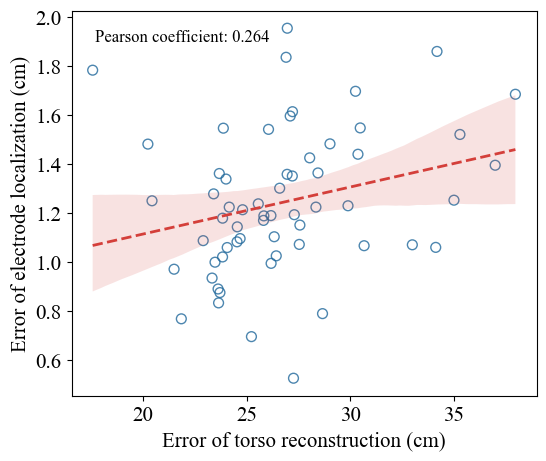

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Set font properties globally
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 15

# Load the Excel file
file_path = './results/results_all.xlsx'  
excel_data = pd.read_excel(file_path, sheet_name='electrodes_manual')  
torso_reconstruction_accuracy = excel_data.iloc[1:61, 1].values  
electrode_localization_accuracy = excel_data.iloc[1:61, 2].values 
BMI_value = excel_data.iloc[1:61, 3].values 

# Create a DataFrame
data = pd.DataFrame({
    'recon': torso_reconstruction_accuracy.tolist(),
    'localizer': electrode_localization_accuracy.tolist()
})

X = data[['recon']].values.reshape(-1, 1)
Y = data['localizer'].values
model = LinearRegression()
model.fit(X, Y)
Y_pred = model.predict(X)
r2 = r2_score(Y, Y_pred)
print(f'R^2: {r2}')


# Calculate correlation coefficient
pearson_corr, pearson_p_value = pearsonr(data['recon'], data['localizer'])
spearman_corr, spearman_p_value = spearmanr(data['recon'], data['localizer'])

print(f"Pearson Correlation Coefficient: {pearson_corr}")
print(f"Spearman's rank correlation coefficient: {spearman_corr}")

# Plot the data
plt.figure(figsize=(6, 5))
# sns.scatterplot(x='recon', y='localizer', data=data, alpha=0.7)
sns.regplot(x='recon', y='localizer', data=data, scatter=True, fit_reg=True, 
            scatter_kws={'s': 50, 'facecolors': 'none', 'edgecolors': '#20689B'}, 
            line_kws={'color': '#D43F3A', 'linewidth': 2, 'linestyle': '--'})
plt.text(0.05, 0.95, f'Pearson coefficient: {pearson_corr:.3f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.xlabel('Error of torso reconstruction (cm)')
plt.ylabel('Error of electrode localization (cm)')
plt.grid(False)
plt.savefig('./results/fig_correlation.pdf', format='pdf')
plt.show()

/var/folders/7k/qhhhfb0177gbf46snn4715qw0000gn/T/ipykernel_7391/806008903.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


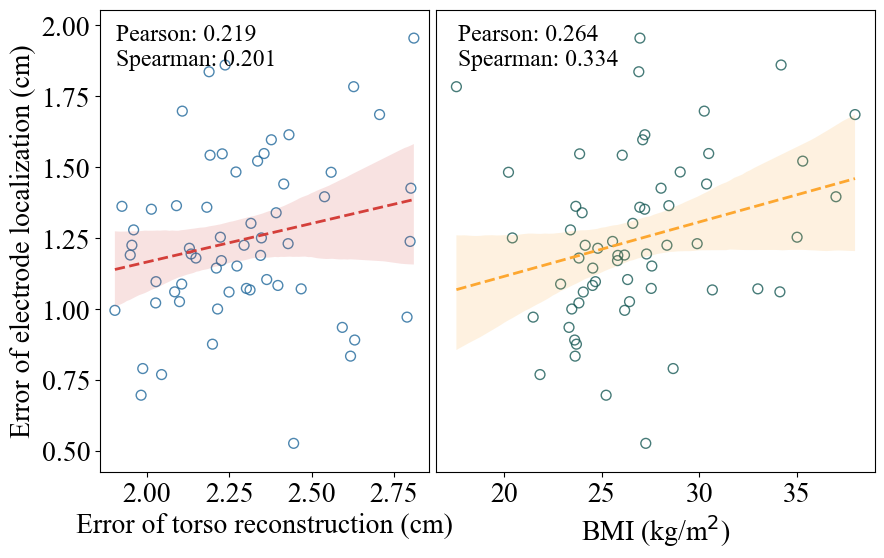

In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Set font properties globally
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 20

# Load the Excel file
file_path = './results/results_all.xlsx'
excel_data = pd.read_excel(file_path, sheet_name='electrodes_manual')
torso_reconstruction_accuracy = excel_data.iloc[1:61, 1].values
electrode_localization_accuracy = excel_data.iloc[1:61, 2].values
BMI_value = excel_data.iloc[1:61, 3].values

# Create DataFrames
data_recon_localizer = pd.DataFrame({
    'recon': torso_reconstruction_accuracy.tolist(),
    'localizer': electrode_localization_accuracy.tolist()
})

data_bmi_localizer = pd.DataFrame({
    'BMI': BMI_value.tolist(),
    'localizer': electrode_localization_accuracy.tolist()
})

# Linear Regression and R^2 for recon vs. localizer
X_recon = data_recon_localizer[['recon']].values.reshape(-1, 1)
Y_localizer = data_recon_localizer['localizer'].values
model_recon = LinearRegression()
model_recon.fit(X_recon, Y_localizer)
Y_pred_recon = model_recon.predict(X_recon)
r2_recon = r2_score(Y_localizer, Y_pred_recon)

# Linear Regression and R^2 for BMI vs. localizer
X_BMI = data_bmi_localizer[['BMI']].values.reshape(-1, 1)
model_BMI = LinearRegression()
model_BMI.fit(X_BMI, Y_localizer)
Y_pred_BMI = model_BMI.predict(X_BMI)
r2_BMI = r2_score(Y_localizer, Y_pred_BMI)

# Calculate correlation coefficients
pearson_corr_recon, _ = pearsonr(data_recon_localizer['recon'], data_recon_localizer['localizer'])
spearman_corr_recon, _ = spearmanr(data_recon_localizer['recon'], data_recon_localizer['localizer'])
pearson_corr_BMI, _ = pearsonr(data_bmi_localizer['BMI'], data_bmi_localizer['localizer'])
spearman_corr_BMI, _ = spearmanr(data_bmi_localizer['BMI'], data_bmi_localizer['localizer'])

# Plot the data using broken x-axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6), gridspec_kw={'width_ratios': [1.5, 2], 'wspace': 0.02})

# Primary axis for torso reconstruction accuracy
sns.regplot(x='recon', y='localizer', data=data_recon_localizer, scatter=True, fit_reg=True,
            scatter_kws={'s': 50, 'facecolors': 'none', 'edgecolors': '#20689B'},
            line_kws={'color': '#D43F3A', 'linewidth': 2, 'linestyle': '--'}, ax=ax1)
ax1.set_xlabel('Error of torso reconstruction (cm)')
ax1.set_ylabel('Error of electrode localization (cm)')
ax1.set_ylim(min(electrode_localization_accuracy) - 0.1, max(electrode_localization_accuracy) + 0.1)
ax1.text(0.05, 0.97, f'Pearson: {pearson_corr_recon:.3f}\nSpearman: {spearman_corr_recon:.3f}',
         transform=ax1.transAxes, fontsize=17, verticalalignment='top')
ax1.set_xticks([2.0, 2.25, 2.5, 2.75])  # Add more ticks for better scale representation

# Secondary axis for BMI vs. localizer
sns.regplot(x='BMI', y='localizer', data=data_bmi_localizer, scatter=True, fit_reg=True,
            scatter_kws={'s': 50, 'facecolors': 'none', 'edgecolors': '#185a56'},
            line_kws={'color': '#fda730', 'linewidth': 2, 'linestyle': '--'}, ax=ax2)
ax2.set_xlabel('BMI (kg/m$^2$)')
ax2.set_ylim(min(electrode_localization_accuracy) - 0.1, max(electrode_localization_accuracy) + 0.1)
ax2.yaxis.set_visible(False)
ax2.text(0.05, 0.97, f'Pearson: {pearson_corr_BMI:.3f}\nSpearman: {spearman_corr_BMI:.3f}',
         transform=ax2.transAxes, fontsize=17, verticalalignment='top')

# Add ellipsis in the middle to indicate the break
#fig.text(0.486, 0.57, '...', ha='center', va='center', fontsize=20)
#fig.text(0.458, 0.08, '...', ha='center', va='center', fontsize=20)

# Adjust the layout
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)
plt.savefig('./results/fig_correlation_combined.pdf', format='pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()


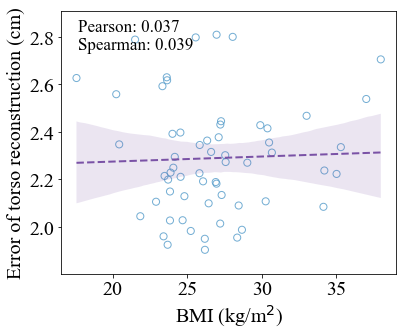

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Set font properties globally
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 20

# Load the Excel file
file_path = './results/results_all.xlsx'
excel_data = pd.read_excel(file_path, sheet_name='electrodes_manual')
torso_reconstruction_accuracy = excel_data.iloc[1:61, 1].values
electrode_localization_accuracy = excel_data.iloc[1:61, 2].values
BMI_value = excel_data.iloc[1:61, 3].values

# Create DataFrame
data_bmi_recon = pd.DataFrame({
    'BMI': BMI_value.tolist(),
    'recon': torso_reconstruction_accuracy.tolist()
})

# Linear Regression and R^2 for BMI vs. recon
X_BMI = data_bmi_recon[['BMI']].values.reshape(-1, 1)
Y_recon = data_bmi_recon[['recon']].values.reshape(-1, 1)
model_BMI = LinearRegression()
model_BMI.fit(X_BMI, Y_recon)
Y_pred_BMI = model_BMI.predict(X_BMI)
r2_BMI = r2_score(Y_recon, Y_pred_BMI)

# Calculate correlation coefficients
pearson_corr_BMI, _ = pearsonr(data_bmi_recon['BMI'], data_bmi_recon['recon'])
spearman_corr_BMI, _ = spearmanr(data_bmi_recon['BMI'], data_bmi_recon['recon'])

# Create a single subplot
fig, ax = plt.subplots(figsize=(6, 5))

scatter_color = '#529ac9'  # Example: blue for scatter points
line_color = '#7a52a6'     # Example: red for the regression line

sns.regplot(x='BMI', y='recon', data=data_bmi_recon, scatter=True, fit_reg=True,
            scatter_kws={'s': 50, 'facecolors': 'none', 'edgecolors': scatter_color},
            line_kws={'color': line_color, 'linewidth': 2, 'linestyle': '--'}, ax=ax)

ax.set_xlabel('BMI (kg/m$^2$)')
ax.set_ylabel('Error of torso reconstruction (cm)')
ax.set_ylim(min(torso_reconstruction_accuracy) - 0.1, max(torso_reconstruction_accuracy) + 0.1)
ax.yaxis.set_visible(True)  # If you want to keep the y-axis visible
ax.text(0.05, 0.97, f'Pearson: {pearson_corr_BMI:.3f}\nSpearman: {spearman_corr_BMI:.3f}',
        transform=ax.transAxes, fontsize=17, verticalalignment='top')

# Adjust the layout
plt.tight_layout()
plt.savefig('./results/fig_correlation_BMI_recon.pdf', format='pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()


R^2: 0.3314570429821351
Pearson Correlation Coefficient: -0.5757230610129618
Spearman's rank correlation coefficient: -0.49090909090909085


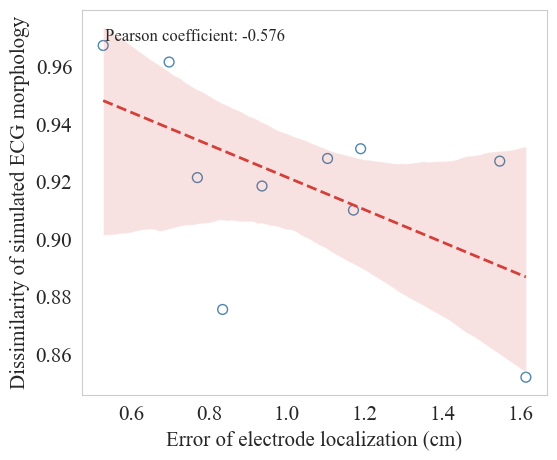

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Set font properties globally
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 15

# Load the Excel file
file_path = './results/results_all.xlsx'  
excel_data = pd.read_excel(file_path, sheet_name='simulation_r')  
electrode_localization_accuracy = excel_data.iloc[1:11, 2].values  
ecg_dtw_accuracy = 1- excel_data.iloc[1:11, 3].values  

# Create a DataFrame
data = pd.DataFrame({
    'localizer': electrode_localization_accuracy.tolist(),
    'ecg': ecg_dtw_accuracy.tolist()
})

X = data[['localizer']].values.reshape(-1, 1)
Y = data['ecg'].values
model = LinearRegression()
model.fit(X, Y)
Y_pred = model.predict(X)
r2 = r2_score(Y, Y_pred)
print(f'R^2: {r2}')


# Calculate correlation coefficient
pearson_corr, pearson_p_value = pearsonr(data['localizer'], data['ecg'])
spearman_corr, spearman_p_value = spearmanr(data['localizer'], data['ecg'])

print(f"Pearson Correlation Coefficient: {pearson_corr}")
print(f"Spearman's rank correlation coefficient: {spearman_corr}")

# Plot the data
plt.figure(figsize=(6, 5))
# sns.scatterplot(x='recon', y='localizer', data=data, alpha=0.7)
sns.regplot(x='localizer', y='ecg', data=data, scatter=True, fit_reg=True, 
            scatter_kws={'s': 50, 'facecolors': 'none', 'edgecolors': '#20689B'}, 
            line_kws={'color': '#D43F3A', 'linewidth': 2, 'linestyle': '--'})
plt.text(0.05, 0.95, f'Pearson coefficient: {pearson_corr:.3f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.xlabel('Error of electrode localization (cm)')
plt.ylabel('Dissimilarity of simulated ECG morphology')
plt.grid(False)
plt.savefig('./results/fig_correlation_simulation.pdf', format='pdf')
plt.show()  


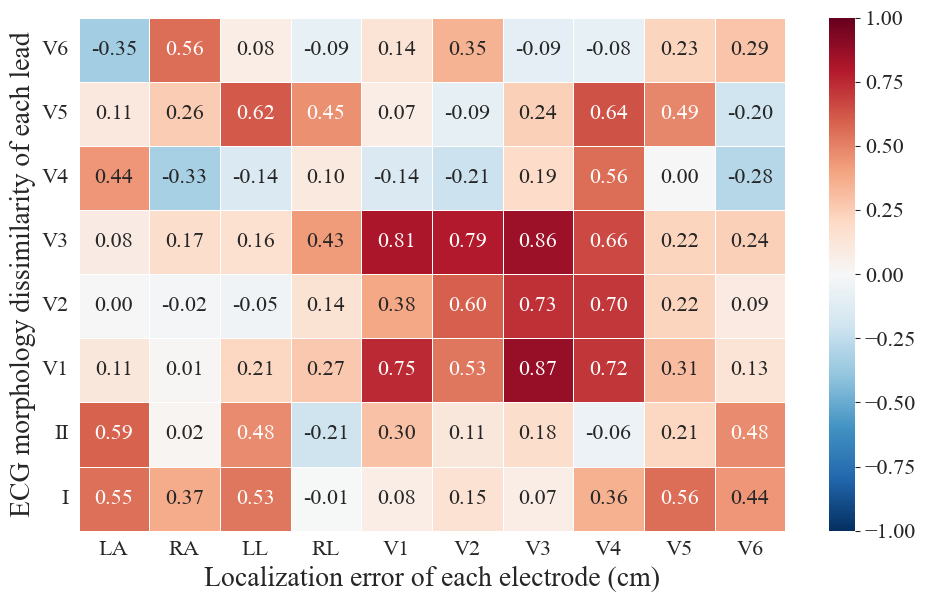

In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from matplotlib.colors import LinearSegmentedColormap

# Set font properties globally
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16

# Load the Excel file
file_path = './results/results_all.xlsx'  
excel_data = pd.read_excel(file_path, sheet_name='simulation_r')  
# df_ecg = excel_data.iloc[1:11, 7:15].values  # person
df_ecg = excel_data.iloc[15:25, 7:15].values  # dtw
df_electrodes = excel_data.iloc[1:11, 18:28].values  

# Convert arrays to DataFrames for easier manipulation
columns_electrodes = ['LA', 'RA', 'LL', 'RL', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
columns_ecg = ['I', 'II', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

df_electrodes = pd.DataFrame(df_electrodes.tolist(), columns=columns_electrodes)
df_ecg = pd.DataFrame(df_ecg.tolist(), columns=columns_ecg)

# Create a correlation matrix
correlation_matrix = pd.DataFrame(index=columns_ecg, columns=columns_electrodes)

for ecg in columns_ecg:
    for electrode in columns_electrodes:
        pearson_corr, _ = pearsonr(df_electrodes[electrode], df_ecg[ecg])
        correlation_matrix.loc[ecg, electrode] = pearson_corr

# Convert correlation matrix to numeric
correlation_matrix = correlation_matrix.apply(pd.to_numeric)

# Reverse the order of ECG Leads in the y-axis
correlation_matrix = correlation_matrix[::-1]

# Create a heatmap
plt.figure(figsize=(10, 6.3))
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0, fmt=".2f", # RdBu_r
            linewidths=0.5, vmin=-1, vmax=1)
# plt.title('Correlation Heatmap between Electrodes and ECG Leads', fontsize=16)
plt.xlabel('Localization error of each electrode (cm)', fontsize=20) # Localization error of each electrode
plt.ylabel('ECG morphology dissimilarity of each lead', fontsize=20) # ECG morphology misalignment of each lead
# plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Save the figure
plt.savefig('./results/fig_correlation_heatmap_r.pdf', format='pdf')
plt.show()


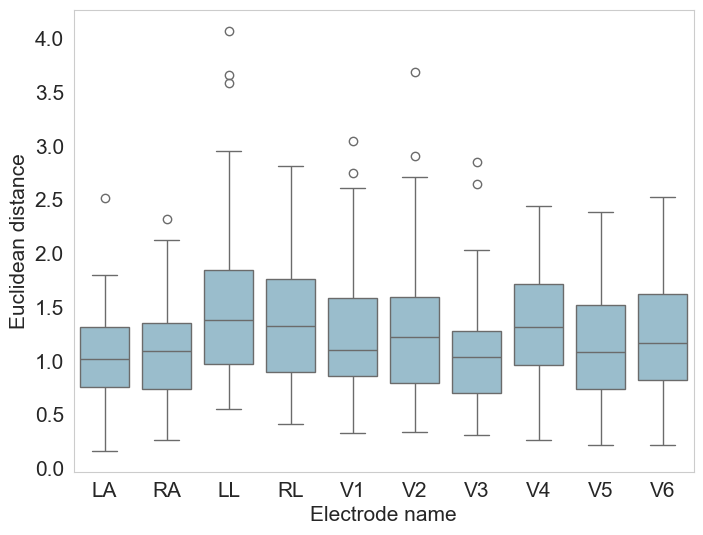

In [28]:
import pyvista as pv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
from scipy.spatial.distance import cdist

# Set font properties globally
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 15

data_list = os.listdir('./results')
electrode_labels_list = ['LA', 'RA', 'LL', 'RL', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
electrode_labels = np.array(electrode_labels_list)[:, np.newaxis]

unit = 0.1

all_distances = {label: [] for label in electrode_labels_list}
distances = []  # To store distances for each subject
subject_labels = []
filename_distances = []  # To store distances with filenames
all_results =  []

for filename in data_list:
    # filename = '1017174'
    # Construct the full file path
    datapath = os.path.join('./dataset_mesh', filename, 'torso_contour_full.vtk')
    if not os.path.exists(datapath):
        # print(f"File {datapath} does not exist.")
        continue
    # cloud = pv.PolyData(datapath)
    # nodesXYZ = cloud.points
    # label_index = cloud.point_data['Labels']
    # pc_electrode_SSM = unit*nodesXYZ[label_index == 1]
    # pc_electrode_SSM_label = np.concatenate((pc_electrode_SSM, electrode_labels), axis=1)

    electrode_pre_path = os.path.join('./results', filename, 'electrodes_TIM_64kp_30rr_pre_v02.csv')
    if not os.path.exists(electrode_pre_path):
        # print(f"File {datapath} does not exist.")
        continue
    pc_electrode_pre = np.loadtxt(electrode_pre_path, delimiter=',')
    pc_electrode_pre_label = np.concatenate((pc_electrode_pre, electrode_labels), axis=1)

    electrode_gd_path = os.path.join('./results/electrode_gd_200cases_by_yilin/after_' + filename + '.csv')
    if not os.path.exists(electrode_gd_path):
        print('file missing: ' + filename)
        continue    
    df = pd.read_csv(electrode_gd_path)
    df[['X', 'Y', 'Z']] *= unit
    # Create a dictionary to map labels to coordinates
    label_to_coords = {label: coords for coords, label in zip(df[['X', 'Y', 'Z']].values, df['Label'])}
    pc_electrode_gd = np.array([label_to_coords[label] for label in electrode_labels_list])

    individual_dist = np.linalg.norm(pc_electrode_gd - pc_electrode_pre, axis=1)
    euclidean_dist = np.mean(individual_dist)
    # print('Electrode localization error: ' + str(euclidean_dist))
    all_results.append(euclidean_dist)

    distances.append(individual_dist)

    # Store distances with labels
    for label, dist in zip(electrode_labels_list, individual_dist):
        subject_labels.append((label, dist))
    
    # Store distances with filename
    filename_distances.append((filename, individual_dist))

df_distances = pd.DataFrame(subject_labels, columns=['Electrode name', 'Euclidean distance'])
# Save the distances of each filename into a CSV file
distance_data = []
for filename, dist in filename_distances:
    distance_data.append([filename] + dist.tolist())
    
df_filename_distances = pd.DataFrame(distance_data, columns=['Filename'] + electrode_labels_list)
df_filename_distances.to_csv('./results/results_each_lead.csv', index=False)

errors_df = pd.DataFrame(all_results)
errors_df.to_csv('./results/results_all_lead.csv', index=False)

# Plot using Seaborn
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")
color = '#91C1D5'
palette = [color] * len(electrode_labels)
ax = sns.boxplot(x='Electrode name', y='Euclidean distance', data=df_distances, palette=palette)

# Customize the boxplot
plt.xlabel('Electrode name')
plt.ylabel('Euclidean distance')
plt.grid(False)
plt.savefig('./results/fig_boxplot_electrodes_TIM.pdf', format='pdf')
plt.show()


In [75]:
import os
import shutil

data_list = os.listdir('./dataset_cardiac_mesh')

for filename in data_list:
    # Construct the full file path
    datapath = os.path.join('./results', filename, 'electrodes_TIM_64kp_30rr_pre_v02.csv')

    # electrode_gd_path = os.path.join('./results/electrode_gd_200cases_by_yilin/after_' + filename + '.csv')
    # if not os.path.exists(electrode_gd_path):
    #     print('file missing: ' + filename)
    #     continue    
    # df = pd.read_csv(electrode_gd_path)
    # df[['X', 'Y', 'Z']] *= unit
    # # Create a dictionary to map labels to coordinates
    # label_to_coords = {label: coords for coords, label in zip(df[['X', 'Y', 'Z']].values, df['Label'])}
    # pc_electrode_gd = np.array([label_to_coords[label] for label in electrode_labels_list])

    # df_to_save = pd.DataFrame(pc_electrode_gd, columns=['X', 'Y', 'Z'])
    # output_path = os.path.join('./results', filename, 'electrodes_TIM_64kp_30rr_pre_v02.csv')
    # os.makedirs(os.path.dirname(output_path), exist_ok=True)
    # df_to_save.to_csv(output_path, index=False, header=False)
    # datapath = output_path

    if not os.path.exists(datapath):
        # print(f"File {datapath} does not exist.")
        continue
    datapath_new = os.path.join('/Users/lei/Library/CloudStorage/OneDrive-UniversityofSouthampton/Oxford/Research/2023_TMI_MI_inference/meta_data/UKB_clinical_data/', filename, filename + '_electrodePositions_pre.csv')

    # Create the directory if it does not exist
    os.makedirs(os.path.dirname(datapath_new), exist_ok=True)
    shutil.copy2(datapath, datapath_new)

    print(f"Copied {datapath} to {datapath_new}")


Copied ./results/1037159/electrodes_TIM_64kp_30rr_pre_v02.csv to /Users/lei/Library/CloudStorage/OneDrive-UniversityofSouthampton/Oxford/Research/2023_TMI_MI_inference/meta_data/UKB_clinical_data/1037159/1037159_electrodePositions_pre.csv
Copied ./results/1036193/electrodes_TIM_64kp_30rr_pre_v02.csv to /Users/lei/Library/CloudStorage/OneDrive-UniversityofSouthampton/Oxford/Research/2023_TMI_MI_inference/meta_data/UKB_clinical_data/1036193/1036193_electrodePositions_pre.csv
Copied ./results/1041615/electrodes_TIM_64kp_30rr_pre_v02.csv to /Users/lei/Library/CloudStorage/OneDrive-UniversityofSouthampton/Oxford/Research/2023_TMI_MI_inference/meta_data/UKB_clinical_data/1041615/1041615_electrodePositions_pre.csv
Copied ./results/1017174/electrodes_TIM_64kp_30rr_pre_v02.csv to /Users/lei/Library/CloudStorage/OneDrive-UniversityofSouthampton/Oxford/Research/2023_TMI_MI_inference/meta_data/UKB_clinical_data/1017174/1017174_electrodePositions_pre.csv
Copied ./results/1042450/electrodes_TIM_64kp

In [47]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm  # For generating unique colors

def ECG_visual_multi_row(ecg_gd, all_ecg_pre, subject_names, gd_label="Ground Truth"):
    leadNames = ['I', 'II', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
    colors = cm.get_cmap('tab10', len(all_ecg_pre))  # Generate a colormap with unique colors for each prediction
    
    fig, axs = plt.subplots(1, 8, constrained_layout=True, figsize=(20, 3))
    
    for i in range(8):  # Iterate over each lead
        leadName = leadNames[i]
        # Plot the ground truth ECG
        axs[i].plot(ecg_gd[i, :], color='black', label=gd_label, linewidth=2)
        
        # Plot each predicted ECG with a unique color
        for j, ecg_pre in enumerate(all_ecg_pre):
            axs[i].plot(ecg_pre[i, :], color=colors(j), label=subject_names[j], linewidth=1.5)

        axs[i].set_title('Lead ' + leadName, fontsize=12)
        axs[i].set_ylim([-2.2, 2.2])  # Align all plots on the same scale
        axs[i].set_axis_off()

    # Create a single legend for all plots
    fig.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
    fig.suptitle('ECG Comparison Across Multiple Subjects')
    fig.savefig('./results/ECG_compare_multiple_subjects.pdf')
    plt.close(fig)

fs = 100  # Assuming a sampling frequency of 100 Hz
datapath = './results/ecg_simulation_visual/1041615/1041615_electrodePositions_gd_variation_test_v03_simulation'
datafile = sorted(glob.glob(datapath + '/PRE_gd*'))

# Load the ground truth ECG
gd_ecg_name = datapath + '/GT.csv'
ecg_gd = np.loadtxt(gd_ecg_name, delimiter=',')

# Load all predicted ECGs and their subject names
all_ecg_pre = []
subject_names = []

for subject_path in datafile:
    subject_name = subject_path.replace(datapath, '').replace('\\', '')
    print("Processing:", subject_name)
    
    ecg_pre = np.loadtxt(subject_path, delimiter=',')
    all_ecg_pre.append(ecg_pre)
    subject_names.append(subject_name.replace('.csv', ''))

# Plot all ECGs together with ground truth
ECG_visual_multi_row(ecg_gd, all_ecg_pre, subject_names)


Processing: PRE_gd_RA_LA_down_3cm.csv
Processing: PRE_gd_RL_LL_down_5cm.csv
Processing: PRE_gd_RL_down_5cm.csv
Processing: PRE_gd_V1_V2_up_3cm.csv
Processing: PRE_gd_V1_right_2cm_V2_left_2cm.csv
Processing: PRE_gd_V3_V4_right_2cm.csv
Processing: PRE_gd_V5_V6_down_3cm.csv


C:\Users\lei.li\AppData\Local\Temp\ipykernel_41576\2444675735.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(all_ecg_pre))  # Generate a colormap with unique colors for each prediction


In [2]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def ECG_visual_single_row(ecg_pre, ecg_gd, subject_name):
    leadNames = ['I', 'II', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

    # fig, axs = plt.subplots(1, 8, constrained_layout=True, figsize=(15, 3))  # Change the subplot shape
    fig, axs = plt.subplots(1, 8, constrained_layout=True, figsize=(15, 3))  # Change the subplot shape
    for i in range(8):
        leadName = leadNames[i]
        axs[i].plot(ecg_pre[i, :], color='#91c1d5', linestyle='--', label='pred', linewidth=2)
        axs[i].plot(ecg_gd[i, :], color='#91c1d5', label='true', linewidth=2)
        axs[i].set_title('Lead ' + leadName, fontsize=12)  # Reduce title fontsize
        axs[i].set_ylim([-2.2, 2.2]) # to align on the 0
        axs[i].set_axis_off() 

    axs[i].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)  # Reduce legend fontsize
    fig.savefig('./results/' + subject_name + '_ECG_compare.pdf')
    # plt.show()
    plt.close(fig)

def calculate_qrs_duration(qrs_signal, fs=1000):
    return len(qrs_signal) / fs * 1000 # in milliseconds

def calculate_r_s_amplitude_ratio(qrs_signal):
    # Assuming the QRS signal is provided and peaks can be identified directly
    r_peak = np.max(qrs_signal)
    s_peak = np.min(qrs_signal)
    return r_peak / abs(s_peak)

fs = 100  # Assuming a sampling frequency of 1000 Hz
# datapath = './dataset_cardiac_mesh'
datapath = './results/ecg_simulation_visual/10_subject_realistic'
datafile = sorted(glob.glob(datapath + '/1*'))

results = []
for subjectid in range(len(datafile)):
    subject_name = datafile[subjectid].replace(datapath, '').replace('\\', '')
    print(subject_name)

    predict_ecg_name = datafile[subjectid] + '/' + subject_name + '_simulated_ECG_normal_pre.csv'
    gd_ecg_name =datafile[subjectid] + '/' + subject_name + '_simulated_ECG_normal_gd.csv'
    ecg_pre = np.loadtxt(predict_ecg_name, delimiter=',')
    ecg_gd = np.loadtxt(gd_ecg_name, delimiter=',')
    ECG_visual_single_row(ecg_pre, ecg_gd, subject_name)

    # Calculate QRS duration
    qrs_duration_pre = calculate_qrs_duration(ecg_pre, fs)
    qrs_duration_gd = calculate_qrs_duration(ecg_gd, fs)

    # Calculate R/S amplitude ratio
    r_s_ratio_pre = calculate_r_s_amplitude_ratio(ecg_pre)
    r_s_ratio_gd = calculate_r_s_amplitude_ratio(ecg_gd)

    results.append([subject_name, qrs_duration_pre, qrs_duration_gd, r_s_ratio_pre, r_s_ratio_gd])
    
    print(f"Predicted QRS Duration: {qrs_duration_pre:.2f} ms")
    print(f"Ground Truth QRS Duration: {qrs_duration_gd:.2f} ms")
    print(f"Predicted R/S Amplitude Ratio: {r_s_ratio_pre:.2f}")
    print(f"Ground Truth R/S Amplitude Ratio: {r_s_ratio_gd:.2f}")
    print()

# Create a DataFrame
results_df = pd.DataFrame(results, columns=['Subject', 'QRS_Duration_Pre (ms)', 'QRS_Duration_GD (ms)', 'R/S_Ratio_Pre', 'R/S_Ratio_GD'])

# Save to CSV
results_df.to_csv('./results/qrs_analysis_results_realistic.csv', index=False)

1017174
Predicted QRS Duration: 80.00 ms
Ground Truth QRS Duration: 80.00 ms
Predicted R/S Amplitude Ratio: 0.71
Ground Truth R/S Amplitude Ratio: 0.70

1032124
Predicted QRS Duration: 80.00 ms
Ground Truth QRS Duration: 80.00 ms
Predicted R/S Amplitude Ratio: 0.65
Ground Truth R/S Amplitude Ratio: 0.61

1035446
Predicted QRS Duration: 80.00 ms
Ground Truth QRS Duration: 80.00 ms
Predicted R/S Amplitude Ratio: 0.78
Ground Truth R/S Amplitude Ratio: 0.70

1036193
Predicted QRS Duration: 80.00 ms
Ground Truth QRS Duration: 80.00 ms
Predicted R/S Amplitude Ratio: 1.38
Ground Truth R/S Amplitude Ratio: 1.26

1037159
Predicted QRS Duration: 80.00 ms
Ground Truth QRS Duration: 80.00 ms
Predicted R/S Amplitude Ratio: 0.69
Ground Truth R/S Amplitude Ratio: 0.79

1038870
Predicted QRS Duration: 80.00 ms
Ground Truth QRS Duration: 80.00 ms
Predicted R/S Amplitude Ratio: 0.89
Ground Truth R/S Amplitude Ratio: 0.84

1039625
Predicted QRS Duration: 80.00 ms
Ground Truth QRS Duration: 80.00 ms
Predi

In [9]:
import os
import shutil

data_list = os.listdir('./results')

for filename in data_list:
    
    datapath = os.path.join('./results', filename, 'electrodes_TIM_no_recon_v02_pre.csv')

    if os.path.exists(datapath):
       os.remove(datapath) 
       print('deleting file: ' + datapath)

deleting file: ./results/1042308/electrodes_TIM_no_recon_v02_pre.csv
deleting file: ./results/1051176/electrodes_TIM_no_recon_v02_pre.csv
deleting file: ./results/1045316/electrodes_TIM_no_recon_v02_pre.csv
deleting file: ./results/1046594/electrodes_TIM_no_recon_v02_pre.csv
deleting file: ./results/1044699/electrodes_TIM_no_recon_v02_pre.csv
deleting file: ./results/1037159/electrodes_TIM_no_recon_v02_pre.csv
deleting file: ./results/1052331/electrodes_TIM_no_recon_v02_pre.csv
deleting file: ./results/1046440/electrodes_TIM_no_recon_v02_pre.csv
deleting file: ./results/1049499/electrodes_TIM_no_recon_v02_pre.csv
deleting file: ./results/1035729/electrodes_TIM_no_recon_v02_pre.csv
deleting file: ./results/1036193/electrodes_TIM_no_recon_v02_pre.csv
deleting file: ./results/1045421/electrodes_TIM_no_recon_v02_pre.csv
deleting file: ./results/1048306/electrodes_TIM_no_recon_v02_pre.csv
deleting file: ./results/1041615/electrodes_TIM_no_recon_v02_pre.csv
deleting file: ./results/1034623/e